In [ ]:
!pip install ultralytics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.3/41.3 kB 1.9 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.

In [ ]:
import os
import random
import shutil
import yaml
import cv2
import glob
import ultralytics
import matplotlib.pyplot as plt
import xml.etree.ElementTree as ET
from ultralytics import YOLO
from ultralytics.utils.plotting import Annotator
from torchvision import transforms
from tqdm import tqdm

In [ ]:
ultralytics.checks()

Ultralytics YOLOv8.2.74 🚀 Python-3.10.12 torch-2.3.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 33.6/201.2 GB disk)


In [ ]:
!kaggle datasets download -d andrewmvd/hard-hat-detection

Dataset URL: https://www.kaggle.com/datasets/andrewmvd/hard-hat-detection
License(s): CC0-1.0
100% 1.22G/1.22G [01:09<00:00, 19.3MB/s]
100% 1.22G/1.22G [01:09<00:00, 19.0MB/s]


In [ ]:
!unzip -q /content/hard-hat-detection.zip

In [ ]:
# helmet_detection 디렉토리를 생성
data_root = '/content/helmet_detection'
# helmet_detection/data 디렉토리를 생성
file_root = f'{data_root}/data'
project_name = 'shd'

train_root = f'{data_root}/{project_name}/train'
valid_root = f'{data_root}/{project_name}/valid'
test_root = f'{data_root}/{project_name}/test'

for folder in [train_root, valid_root, test_root]:
    if not os.path.exists(folder):
        os.makedirs(folder)
    for s in ['images', 'labels']:
        s_folder = f'{folder}/{s}'
        if not os.path.exists(s_folder):
            os.makedirs(s_folder)

In [ ]:
# helmet_detection/data 디렉토리에 images, annotations를 넣어줌
file_list = glob.glob(f'{file_root}/images/*.png')
len(file_list)

5000

In [ ]:
def xml_to_yolo_bbox(bbox, w, h):
    # xmin, ymin, xmax, ymax
    x_center = ((bbox[2] + bbox[0]) / 2) / w
    y_center = ((bbox[3] + bbox[1]) / 2) / h
    width = (bbox[2] - bbox[0]) / w
    height = (bbox[3] - bbox[1]) / h
    return [x_center, y_center, width, height]

In [ ]:
# /content/helmet_detection/data/labels 디렉토리 생성

classes = []
for file in tqdm(file_list):
    file_name = file.split('/')[-1].replace('png', 'xml')
    save_name = file_name.replace('xml', 'txt')
    file_path = f'{file_root}/annotations/{file_name}'
    save_path = f'{file_root}/labels/{save_name}'

    result = list()
    tree = ET.parse(file_path)
    root = tree.getroot()
    width = int(root.find('size').find('width').text)
    height = int(root.find('size').find('height').text)
    for obj in root.findall('object'):
        label = obj.find('name').text
        if label not in classes:
            classes.append(label)
        index = classes.index(label)
        pil_bbox = [int(x.text) for x in obj.find('bndbox')]
        yolo_bbox = xml_to_yolo_bbox(pil_bbox, width, height)
        bbox_string = ' '.join([str(x) for x in yolo_bbox])
        result.append(f'{index} {bbox_string}')
    if result:
        with open(save_path, 'w', encoding='utf-8') as f:
            f.write('\n'.join(result))

100%|██████████| 5000/5000 [00:01<00:00, 3796.37it/s]


In [ ]:
classes

['head', 'helmet', 'person']

In [ ]:
cls_list = ['head', 'helmet', 'person']

In [ ]:
random.seed(2024)

In [ ]:
random.shuffle(file_list)
test_ratio = 0.1
num_file = len(file_list)

test_list = file_list[:int(num_file*test_ratio)]
valid_list = file_list[int(num_file*test_ratio):int(num_file*test_ratio)*2]
train_list = file_list[int(num_file*test_ratio)*2:]

In [ ]:
for i in test_list:
    label_name = i.split('/')[-1].replace('png', 'txt')
    label_path = f'{file_root}/labels/{label_name}'
    shutil.copyfile(label_path, f'{test_root}/labels/{label_name}')
    img_name = i.split('/')[-1]
    shutil.copyfile(i, f'{test_root}/images/{img_name}')

for i in valid_list:
    label_name = i.split('/')[-1].replace('png', 'txt')
    label_path = f'{file_root}/labels/{label_name}'
    shutil.copyfile(label_path, f'{valid_root}/labels/{label_name}')
    img_name = i.split('/')[-1]
    shutil.copyfile(i, f'{valid_root}/images/{img_name}')

for i in train_list:
    label_name = i.split('/')[-1].replace('png', 'txt')
    label_path = f'{file_root}/labels/{label_name}'
    shutil.copyfile(label_path, f'{train_root}/labels/{label_name}')
    img_name = i.split('/')[-1]
    shutil.copyfile(i, f'{train_root}/images/{img_name}')

In [ ]:
project_root = '/content/helmet_detection'

In [ ]:
data = dict()

data['train'] = train_root
data['val'] = valid_root
data['test'] = test_root
data['nc'] = len(cls_list)
data['names'] = cls_list

with open(f'{project_root}/safety_helmet.yaml', 'w') as f:
    yaml.dump(data, f)

In [ ]:
%cd /content/helmet_detection

/content/helmet_detection


In [ ]:
model = YOLO('yolov8n.pt')
results = model.train(data='safety_helmet.yaml', epochs=2, batch=8, imgsz=224, device=0, workers=4, amp=False, patience=30, name='safety_n')

100%|██████████| 6.25M/6.25M [00:00<00:00, 316MB/s]

Ultralytics YOLOv8.2.74 🚀 Python-3.10.12 torch-2.3.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=safety_helmet.yaml, epochs=2, time=None, patience=30, batch=8, imgsz=224, save=True, save_period=-1, cache=False, device=0, workers=4, project=None, name=safety_n, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=False, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_boxes=True

100%|██████████| 755k/755k [00:00<00:00, 105MB/s]


Overriding model.yaml nc=80 with nc=3

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralytics

train: Scanning /content/helmet_detection/shd/train/labels... 4000 images, 0 backgrounds, 0 corrupt: 100%|██████████| 4000/4000 [00:03<00:00, 1045.09it/s]


train: New cache created: /content/helmet_detection/shd/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
val: Scanning /content/helmet_detection/shd/valid/labels... 500 images, 0 backgrounds, 0 corrupt: 100%|██████████| 500/500 [00:00<00:00, 709.98it/s]


val: New cache created: /content/helmet_detection/shd/valid/labels.cache
Plotting labels to runs/detect/safety_n/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001429, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 224 train, 224 val
Using 2 dataloader workers
Logging results to runs/detect/safety_n
Starting training for 2 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/2     0.862G      1.862      1.863      1.124         72        224: 100%|██████████| 500/500 [01:17<00:00,  6.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:08<00:00,  3.77it/s]

                   all        500       2583      0.802      0.399      0.431      0.222



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/2      0.83G      1.637      1.221       1.05         94        224: 100%|██████████| 500/500 [01:09<00:00,  7.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:05<00:00,  6.06it/s]


                   all        500       2583      0.866      0.433      0.493      0.276

2 epochs completed in 0.047 hours.
Optimizer stripped from runs/detect/safety_n/weights/last.pt, 6.2MB
Optimizer stripped from runs/detect/safety_n/weights/best.pt, 6.2MB

Validating runs/detect/safety_n/weights/best.pt...
Ultralytics YOLOv8.2.74 🚀 Python-3.10.12 torch-2.3.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 168 layers, 3,006,233 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:11<00:00,  2.81it/s]


                   all        500       2583      0.867      0.432      0.493      0.276
                  head         84        565      0.819      0.543      0.661      0.366
                helmet        462       1932      0.781      0.754      0.802      0.455
                person         20         86          1          0     0.0152    0.00691
Speed: 0.1ms preprocess, 2.1ms inference, 0.0ms loss, 3.1ms postprocess per image
Results saved to runs/detect/safety_n


In [ ]:
model = YOLO('yolov8s.pt')
results = model.train(data='safety_helmet.yaml', epochs=2, batch=8, imgsz=224, device=0, workers=4, amp=False, patience=30, name='safety_s')

100%|██████████| 21.5M/21.5M [00:00<00:00, 43.2MB/s]

Ultralytics YOLOv8.2.74 🚀 Python-3.10.12 torch-2.3.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=yolov8s.pt, data=safety_helmet.yaml, epochs=2, time=None, patience=30, batch=8, imgsz=224, save=True, save_period=-1, cache=False, device=0, workers=4, project=None, name=safety_s, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=False, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_boxes=True

 12                  -1  1    591360  ultralytics.nn.modules.block.C2f             [768, 256, 1]                 
 13                  -1  1         0  torch.nn.modules.upsampling.Upsample         [None, 2, 'nearest']          
 14             [-1, 4]  1         0  ultralytics.nn.modules.conv.Concat           [1]                           
 15                  -1  1    148224  ultralytics.nn.modules.block.C2f             [384, 128, 1]                 
 16                  -1  1    147712  ultralytics.nn.modules.conv.Conv             [128, 128, 3, 2]              
 17            [-1, 12]  1         0  ultralytics.nn.modules.conv.Concat           [1]                           
 18                  -1  1    493056  ultralytics.nn.modules.block.C2f             [384, 256, 1]                 
 19                  -1  1    590336  ultralytics.nn.modules.conv.Conv             [256, 256, 3, 2]              
 20             [-1, 9]  1         0  ultralytics.nn.modules.conv.Concat           [1]  

train: Scanning /content/helmet_detection/shd/train/labels.cache... 4000 images, 0 backgrounds, 0 corrupt: 100%|██████████| 4000/4000 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
val: Scanning /content/helmet_detection/shd/valid/labels.cache... 500 images, 0 backgrounds, 0 corrupt: 100%|██████████| 500/500 [00:00<?, ?it/s]


Plotting labels to runs/detect/safety_s/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001429, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 224 train, 224 val
Using 2 dataloader workers
Logging results to runs/detect/safety_s
Starting training for 2 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/2      1.38G       1.69      1.385      1.103         72        224: 100%|██████████| 500/500 [01:13<00:00,  6.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:08<00:00,  3.92it/s]

                   all        500       2583      0.862      0.452      0.499      0.285



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/2      1.42G      1.512      1.003       1.04         94        224: 100%|██████████| 500/500 [01:13<00:00,  6.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:04<00:00,  6.99it/s]

                   all        500       2583      0.889      0.492      0.543      0.318



2 epochs completed in 0.050 hours.
Optimizer stripped from runs/detect/safety_s/weights/last.pt, 22.5MB
Optimizer stripped from runs/detect/safety_s/weights/best.pt, 22.5MB

Validating runs/detect/safety_s/weights/best.pt...
Ultralytics YOLOv8.2.74 🚀 Python-3.10.12 torch-2.3.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 168 layers, 11,126,745 parameters, 0 gradients, 28.4 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:12<00:00,  2.57it/s]


                   all        500       2583      0.889      0.493      0.543      0.318
                  head         84        565      0.803       0.71      0.768      0.442
                helmet        462       1932      0.864      0.768      0.846      0.507
                person         20         86          1          0     0.0158    0.00518
Speed: 0.1ms preprocess, 3.1ms inference, 0.0ms loss, 4.4ms postprocess per image
Results saved to runs/detect/safety_s


In [ ]:
model = YOLO('yolov8m.pt')
results = model.train(data='safety_helmet.yaml', epochs=2, batch=8, imgsz=224, device=0, workers=4, amp=False, patience=30, name='safety_m')

100%|██████████| 49.7M/49.7M [00:00<00:00, 256MB/s]


Ultralytics YOLOv8.2.74 🚀 Python-3.10.12 torch-2.3.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=yolov8m.pt, data=safety_helmet.yaml, epochs=2, time=None, patience=30, batch=8, imgsz=224, save=True, save_period=-1, cache=False, device=0, workers=4, project=None, name=safety_m, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=False, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_boxes=True

train: Scanning /content/helmet_detection/shd/train/labels.cache... 4000 images, 0 backgrounds, 0 corrupt: 100%|██████████| 4000/4000 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
val: Scanning /content/helmet_detection/shd/valid/labels.cache... 500 images, 0 backgrounds, 0 corrupt: 100%|██████████| 500/500 [00:00<?, ?it/s]


Plotting labels to runs/detect/safety_m/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001429, momentum=0.9) with parameter groups 77 weight(decay=0.0), 84 weight(decay=0.0005), 83 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 224 train, 224 val
Using 2 dataloader workers
Logging results to runs/detect/safety_m
Starting training for 2 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/2      1.91G      1.636      1.293      1.092         72        224: 100%|██████████| 500/500 [01:51<00:00,  4.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:07<00:00,  4.19it/s]

                   all        500       2583      0.865      0.432       0.48      0.263



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/2      1.69G      1.494     0.9846      1.042         94        224: 100%|██████████| 500/500 [01:21<00:00,  6.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:04<00:00,  6.46it/s]


                   all        500       2583      0.911        0.5      0.559      0.317

2 epochs completed in 0.059 hours.
Optimizer stripped from runs/detect/safety_m/weights/last.pt, 52.0MB
Optimizer stripped from runs/detect/safety_m/weights/best.pt, 52.0MB

Validating runs/detect/safety_m/weights/best.pt...
Ultralytics YOLOv8.2.74 🚀 Python-3.10.12 torch-2.3.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 218 layers, 25,841,497 parameters, 0 gradients, 78.7 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:12<00:00,  2.65it/s]


                   all        500       2583      0.913      0.499      0.559      0.317
                  head         84        565      0.855      0.708      0.793      0.445
                helmet        462       1932      0.885      0.789      0.869      0.502
                person         20         86          1          0     0.0141    0.00481
Speed: 0.1ms preprocess, 4.1ms inference, 0.0ms loss, 3.4ms postprocess per image
Results saved to runs/detect/safety_m


In [ ]:
%cd /content/helmet_detection

/content/helmet_detection


In [ ]:
result_folder = f'{project_root}/runs/detect'

In [ ]:
model = YOLO(f'{result_folder}/safety_n/weights/best.pt')
metrics = model.val(split='test')
print('map50-95', metrics.box.map)
print('map50', metrics.box.map)

Ultralytics YOLOv8.2.74 🚀 Python-3.10.12 torch-2.3.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 168 layers, 3,006,233 parameters, 0 gradients, 8.1 GFLOPs


val: Scanning /content/helmet_detection/shd/test/labels... 500 images, 0 backgrounds, 0 corrupt: 100%|██████████| 500/500 [00:01<00:00, 322.88it/s]

val: New cache created: /content/helmet_detection/shd/test/labels.cache



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:11<00:00,  2.84it/s]


                   all        500       2593      0.887      0.407      0.481      0.269
                  head         87        499      0.892      0.513      0.666      0.376
                helmet        465       2021       0.77      0.709      0.766      0.427
                person         14         73          1          0      0.011    0.00452
Speed: 0.1ms preprocess, 3.4ms inference, 0.0ms loss, 3.9ms postprocess per image
Results saved to runs/detect/val
map50-95 0.26919530087935467
map50 0.26919530087935467


In [ ]:
model = YOLO(f'{result_folder}/safety_s/weights/best.pt')
metrics = model.val(split='test')
print('map50-95', metrics.box.map)
print('map50', metrics.box.map)

Ultralytics YOLOv8.2.74 🚀 Python-3.10.12 torch-2.3.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 168 layers, 11,126,745 parameters, 0 gradients, 28.4 GFLOPs


val: Scanning /content/helmet_detection/shd/test/labels.cache... 500 images, 0 backgrounds, 0 corrupt: 100%|██████████| 500/500 [00:00<?, ?it/s]
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:12<00:00,  2.58it/s]


                   all        500       2593      0.908      0.454      0.524      0.308
                  head         87        499      0.847      0.651      0.747      0.437
                helmet        465       2021      0.878      0.711      0.818      0.485
                person         14         73          1          0    0.00775    0.00353
Speed: 0.1ms preprocess, 4.5ms inference, 0.0ms loss, 4.1ms postprocess per image
Results saved to runs/detect/val2
map50-95 0.3084720315712921
map50 0.3084720315712921


In [ ]:
model = YOLO(f'{result_folder}/safety_m/weights/best.pt')
metrics = model.val(split='test')
print('map50-95', metrics.box.map)
print('map50', metrics.box.map)

Ultralytics YOLOv8.2.74 🚀 Python-3.10.12 torch-2.3.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 218 layers, 25,841,497 parameters, 0 gradients, 78.7 GFLOPs


val: Scanning /content/helmet_detection/shd/test/labels.cache... 500 images, 0 backgrounds, 0 corrupt: 100%|██████████| 500/500 [00:00<?, ?it/s]
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:13<00:00,  2.42it/s]


                   all        500       2593      0.903      0.483      0.545      0.312
                  head         87        499      0.846      0.683      0.771      0.447
                helmet        465       2021      0.864      0.765      0.843      0.477
                person         14         73          1          0     0.0205     0.0125
Speed: 0.2ms preprocess, 6.1ms inference, 0.0ms loss, 3.3ms postprocess per image
Results saved to runs/detect/val3
map50-95 0.3122021028934109
map50 0.3122021028934109


In [ ]:
model = YOLO('yolov8n.pt')
results = model.train(data='safety_helmet.yaml', epochs=50, batch=8, imgsz=224, device=0, workers=4, amp=False, patience=30, name='safety')

Ultralytics YOLOv8.2.74 🚀 Python-3.10.12 torch-2.3.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=safety_helmet.yaml, epochs=50, time=None, patience=30, batch=8, imgsz=224, save=True, save_period=-1, cache=False, device=0, workers=4, project=None, name=safety, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=False, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_boxes=True,

train: Scanning /content/helmet_detection/shd/train/labels.cache... 4000 images, 0 backgrounds, 0 corrupt: 100%|██████████| 4000/4000 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
val: Scanning /content/helmet_detection/shd/valid/labels.cache... 500 images, 0 backgrounds, 0 corrupt: 100%|██████████| 500/500 [00:00<?, ?it/s]


Plotting labels to runs/detect/safety/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001429, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 224 train, 224 val
Using 2 dataloader workers
Logging results to runs/detect/safety
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50      1.59G      1.862      1.863      1.124         72        224: 100%|██████████| 500/500 [01:19<00:00,  6.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:04<00:00,  6.50it/s]


                   all        500       2583      0.802      0.399      0.431      0.222

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50      0.74G      1.698      1.279      1.074         94        224: 100%|██████████| 500/500 [01:18<00:00,  6.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:05<00:00,  6.28it/s]


                   all        500       2583      0.822      0.403      0.454       0.25

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50     0.734G      1.662      1.206      1.063         51        224: 100%|██████████| 500/500 [01:13<00:00,  6.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:08<00:00,  3.59it/s]


                   all        500       2583      0.856      0.418      0.476       0.26

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50     0.734G       1.64      1.157      1.062         50        224: 100%|██████████| 500/500 [01:11<00:00,  7.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:04<00:00,  6.64it/s]


                   all        500       2583      0.888      0.418      0.491      0.269

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50     0.732G      1.605       1.12      1.052         43        224: 100%|██████████| 500/500 [01:13<00:00,  6.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:06<00:00,  4.94it/s]

                   all        500       2583       0.89      0.454      0.513      0.288



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50     0.732G      1.591      1.086      1.037         42        224: 100%|██████████| 500/500 [01:10<00:00,  7.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:07<00:00,  4.26it/s]


                   all        500       2583      0.894      0.435      0.507      0.288

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50     0.732G       1.57      1.072      1.038         28        224: 100%|██████████| 500/500 [01:12<00:00,  6.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:04<00:00,  6.67it/s]


                   all        500       2583      0.821      0.446      0.503      0.279

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50     0.732G      1.552      1.046      1.035         75        224: 100%|██████████| 500/500 [01:11<00:00,  6.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:08<00:00,  3.70it/s]

                   all        500       2583        0.9      0.448      0.527        0.3



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50     0.732G      1.524      1.015      1.026         68        224: 100%|██████████| 500/500 [01:10<00:00,  7.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:04<00:00,  6.53it/s]


                   all        500       2583      0.893      0.476      0.536      0.306

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50     0.732G      1.517      1.002      1.017         48        224: 100%|██████████| 500/500 [01:13<00:00,  6.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:05<00:00,  5.74it/s]

                   all        500       2583      0.889       0.46      0.528      0.309



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50     0.732G      1.503     0.9827      1.019         51        224: 100%|██████████| 500/500 [01:09<00:00,  7.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:08<00:00,  3.73it/s]


                   all        500       2583      0.891      0.466      0.535      0.303

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50     0.732G      1.493     0.9752      1.013         58        224: 100%|██████████| 500/500 [01:11<00:00,  6.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:04<00:00,  6.87it/s]

                   all        500       2583      0.899      0.481      0.544      0.317



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50     0.732G      1.481     0.9493      1.007         44        224: 100%|██████████| 500/500 [01:12<00:00,  6.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:08<00:00,  3.74it/s]


                   all        500       2583      0.898      0.493      0.542      0.312

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50     0.732G      1.481     0.9633      1.008         65        224: 100%|██████████| 500/500 [01:10<00:00,  7.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:04<00:00,  6.67it/s]

                   all        500       2583      0.907      0.475      0.546       0.32



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50     0.732G      1.466     0.9463      1.007         90        224: 100%|██████████| 500/500 [01:13<00:00,  6.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:04<00:00,  6.44it/s]

                   all        500       2583      0.911      0.477      0.549      0.316



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50     0.732G       1.46     0.9376      1.005         71        224: 100%|██████████| 500/500 [01:09<00:00,  7.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:08<00:00,  3.67it/s]


                   all        500       2583      0.901       0.47      0.541      0.308

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50     0.732G      1.448     0.9265      1.002         59        224: 100%|██████████| 500/500 [01:11<00:00,  6.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:04<00:00,  6.88it/s]

                   all        500       2583      0.912      0.492      0.553      0.327



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50     0.732G      1.436     0.9202     0.9941         65        224: 100%|██████████| 500/500 [01:11<00:00,  6.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:07<00:00,  4.37it/s]


                   all        500       2583      0.914      0.483      0.562      0.335

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50     0.732G      1.436     0.9147     0.9923         76        224: 100%|██████████| 500/500 [01:09<00:00,  7.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:05<00:00,  5.59it/s]


                   all        500       2583      0.917      0.493      0.566      0.333

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50     0.732G      1.431     0.9053     0.9898         68        224: 100%|██████████| 500/500 [01:13<00:00,  6.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:04<00:00,  7.26it/s]

                   all        500       2583      0.915      0.494      0.559      0.331



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50     0.732G      1.423     0.9059     0.9931         37        224: 100%|██████████| 500/500 [01:10<00:00,  7.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:09<00:00,  3.47it/s]


                   all        500       2583      0.906      0.494      0.558      0.337

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50     0.732G      1.412     0.8941     0.9897         25        224: 100%|██████████| 500/500 [01:10<00:00,  7.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:04<00:00,  6.86it/s]


                   all        500       2583      0.918      0.494      0.565      0.336

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50     0.732G      1.408     0.8779     0.9836         88        224: 100%|██████████| 500/500 [01:11<00:00,  6.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:08<00:00,  3.59it/s]

                   all        500       2583      0.904      0.509      0.565      0.342



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50     0.732G      1.401     0.8817     0.9916         61        224: 100%|██████████| 500/500 [01:12<00:00,  6.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:06<00:00,  5.28it/s]


                   all        500       2583      0.913      0.509      0.573      0.347

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50     0.732G      1.393     0.8648     0.9835         28        224: 100%|██████████| 500/500 [01:17<00:00,  6.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:05<00:00,  6.25it/s]


                   all        500       2583      0.906      0.502      0.569      0.343

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50     0.732G      1.394     0.8659     0.9848         31        224: 100%|██████████| 500/500 [01:13<00:00,  6.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:07<00:00,  4.19it/s]


                   all        500       2583      0.919      0.506      0.575      0.344

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50     0.732G      1.371     0.8571     0.9784         33        224: 100%|██████████| 500/500 [01:16<00:00,  6.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:05<00:00,  6.39it/s]

                   all        500       2583      0.841      0.528      0.576      0.347



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50     0.732G      1.374      0.847     0.9771         87        224: 100%|██████████| 500/500 [01:16<00:00,  6.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:07<00:00,  4.53it/s]

                   all        500       2583       0.92      0.514      0.583      0.345



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50     0.732G      1.375     0.8453     0.9771        108        224: 100%|██████████| 500/500 [01:13<00:00,  6.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:07<00:00,  4.49it/s]


                   all        500       2583      0.915      0.512      0.583      0.355

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50     0.734G      1.359     0.8411     0.9737         37        224: 100%|██████████| 500/500 [01:16<00:00,  6.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:05<00:00,  6.31it/s]

                   all        500       2583      0.921      0.515      0.579      0.348



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50     0.732G      1.345     0.8227     0.9696         90        224: 100%|██████████| 500/500 [01:10<00:00,  7.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:08<00:00,  3.79it/s]


                   all        500       2583      0.905      0.519      0.573      0.345

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50     0.732G      1.358     0.8398     0.9759         36        224: 100%|██████████| 500/500 [01:12<00:00,  6.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:04<00:00,  6.84it/s]

                   all        500       2583      0.914      0.514      0.582      0.348



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50     0.732G      1.341     0.8274     0.9729         90        224: 100%|██████████| 500/500 [01:16<00:00,  6.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:08<00:00,  3.81it/s]

                   all        500       2583      0.932      0.511      0.582       0.35



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50     0.732G      1.347     0.8201      0.969         69        224: 100%|██████████| 500/500 [01:10<00:00,  7.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:06<00:00,  4.59it/s]


                   all        500       2583      0.919      0.523      0.583      0.352

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50     0.732G      1.346     0.8197     0.9723         85        224: 100%|██████████| 500/500 [01:14<00:00,  6.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:04<00:00,  6.61it/s]

                   all        500       2583      0.918      0.524      0.578      0.351



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50     0.732G      1.343     0.8169     0.9671         21        224: 100%|██████████| 500/500 [01:14<00:00,  6.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:06<00:00,  4.76it/s]


                   all        500       2583      0.931      0.511       0.58      0.354

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50     0.732G      1.327      0.808     0.9661         72        224: 100%|██████████| 500/500 [01:12<00:00,  6.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:05<00:00,  5.48it/s]


                   all        500       2583      0.849      0.544      0.585      0.355

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50     0.732G      1.328     0.8046     0.9642         65        224: 100%|██████████| 500/500 [01:15<00:00,  6.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:04<00:00,  6.41it/s]

                   all        500       2583      0.915      0.526      0.584      0.355



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50     0.732G      1.311     0.7959     0.9628         51        224: 100%|██████████| 500/500 [01:12<00:00,  6.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:08<00:00,  3.63it/s]


                   all        500       2583      0.733       0.54      0.586      0.358

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50     0.732G      1.307     0.7907     0.9616         38        224: 100%|██████████| 500/500 [01:12<00:00,  6.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:04<00:00,  6.94it/s]


                   all        500       2583      0.721      0.539      0.592      0.365
Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50     0.732G      1.247     0.6968     0.9511         60        224: 100%|██████████| 500/500 [01:14<00:00,  6.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:05<00:00,  5.94it/s]


                   all        500       2583      0.931      0.525      0.588      0.364

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50     0.732G      1.242     0.6839     0.9468         41        224: 100%|██████████| 500/500 [01:08<00:00,  7.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:06<00:00,  5.09it/s]


                   all        500       2583      0.904      0.542      0.593      0.363

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50     0.732G      1.226     0.6656     0.9383         48        224: 100%|██████████| 500/500 [01:10<00:00,  7.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:05<00:00,  5.88it/s]

                   all        500       2583      0.617      0.542      0.589      0.363



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50     0.732G      1.227     0.6648     0.9372         35        224: 100%|██████████| 500/500 [01:07<00:00,  7.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:07<00:00,  4.33it/s]


                   all        500       2583      0.913      0.537      0.592      0.362

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50     0.732G      1.209     0.6556     0.9361         40        224: 100%|██████████| 500/500 [01:11<00:00,  7.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:04<00:00,  6.80it/s]

                   all        500       2583      0.934      0.514      0.593      0.366



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/50     0.732G      1.208     0.6527     0.9374         40        224: 100%|██████████| 500/500 [01:08<00:00,  7.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:08<00:00,  3.71it/s]


                   all        500       2583      0.818      0.538      0.594       0.37

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/50     0.732G      1.208     0.6538     0.9363         33        224: 100%|██████████| 500/500 [01:08<00:00,  7.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:04<00:00,  6.63it/s]

                   all        500       2583      0.801      0.529      0.592      0.369



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/50     0.732G      1.205      0.649     0.9355         22        224: 100%|██████████| 500/500 [01:12<00:00,  6.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:08<00:00,  3.87it/s]

                   all        500       2583      0.848       0.53      0.595      0.371



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/50     0.732G      1.193     0.6383      0.933         27        224: 100%|██████████| 500/500 [01:07<00:00,  7.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:06<00:00,  4.66it/s]


                   all        500       2583      0.864      0.531      0.595      0.371

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/50     0.732G      1.191     0.6363     0.9324         44        224: 100%|██████████| 500/500 [01:11<00:00,  7.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:04<00:00,  7.01it/s]


                   all        500       2583      0.833      0.528      0.595       0.37

50 epochs completed in 1.108 hours.
Optimizer stripped from runs/detect/safety/weights/last.pt, 6.2MB
Optimizer stripped from runs/detect/safety/weights/best.pt, 6.2MB

Validating runs/detect/safety/weights/best.pt...
Ultralytics YOLOv8.2.74 🚀 Python-3.10.12 torch-2.3.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 168 layers, 3,006,233 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:11<00:00,  2.68it/s]


                   all        500       2583      0.847       0.53      0.595      0.371
                  head         84        565      0.872      0.757       0.83      0.504
                helmet        462       1932      0.932      0.822      0.903      0.577
                person         20         86      0.738     0.0116     0.0522     0.0334
Speed: 0.1ms preprocess, 2.4ms inference, 0.0ms loss, 3.2ms postprocess per image
Results saved to runs/detect/safety


In [ ]:
model = YOLO(f'{result_folder}/safety/weights/best.pt')
metrics = model.val(split='test')
print('map50-95', metrics.box.map)
print('map50', metrics.box.map)

Ultralytics YOLOv8.2.74 🚀 Python-3.10.12 torch-2.3.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 168 layers, 3,006,233 parameters, 0 gradients, 8.1 GFLOPs


val: Scanning /content/helmet_detection/shd/test/labels.cache... 500 images, 0 backgrounds, 0 corrupt: 100%|██████████| 500/500 [00:00<?, ?it/s]
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:11<00:00,  2.78it/s]


                   all        500       2593      0.595      0.507      0.567      0.355
                  head         87        499      0.861      0.735      0.807      0.507
                helmet        465       2021      0.923      0.787      0.877      0.551
                person         14         73          0          0     0.0175    0.00787
Speed: 0.1ms preprocess, 3.0ms inference, 0.0ms loss, 3.6ms postprocess per image
Results saved to runs/detect/val4
map50-95 0.355116109546678
map50 0.355116109546678


In [ ]:
data_root = '/content/helmet_detection'
project_name = 'shd'
test_root = f'{data_root}/{project_name}/test'

test_file_list = glob.glob(f'{test_root}/images/*')
random.shuffle(test_file_list)

In [ ]:
IMG_SIZE = (224, 224)
test_data_transform = transforms.Compose([
    transforms.Resize(IMG_SIZE),
    transforms.ToTensor()
])

In [ ]:
model.names

{0: 'head', 1: 'helmet', 2: 'person'}

In [ ]:
# color_dict = [[random.randint(0, 255) for _ in range(3)] for _ in range(0, len(model.names))]
# color_dict
color_dict = {i: tuple([random.randint(0, 255) for _ in range(3)]) for i in range(len(model.names))}
color_dict

[[153, 7, 229], [169, 82, 76], [235, 190, 195]]

In [ ]:
test_img = cv2.imread(test_file_list[3])
img_src = cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB)
result = model(img_src)


0: 224x224 1 helmet, 10.7ms
Speed: 1.2ms preprocess, 10.7ms inference, 2.5ms postprocess per image at shape (1, 3, 224, 224)


In [ ]:
result[0].boxes

ultralytics.engine.results.Boxes object with attributes:

cls: tensor([1.], device='cuda:0')
conf: tensor([0.7466], device='cuda:0')
data: tensor([[246.0621, 118.1428, 274.1810, 157.5771,   0.7466,   1.0000]], device='cuda:0')
id: None
is_track: False
orig_shape: (416, 416)
shape: torch.Size([1, 6])
xywh: tensor([[260.1216, 137.8600,  28.1189,  39.4343]], device='cuda:0')
xywhn: tensor([[0.6253, 0.3314, 0.0676, 0.0948]], device='cuda:0')
xyxy: tensor([[246.0621, 118.1428, 274.1810, 157.5771]], device='cuda:0')
xyxyn: tensor([[0.5915, 0.2840, 0.6591, 0.3788]], device='cuda:0')

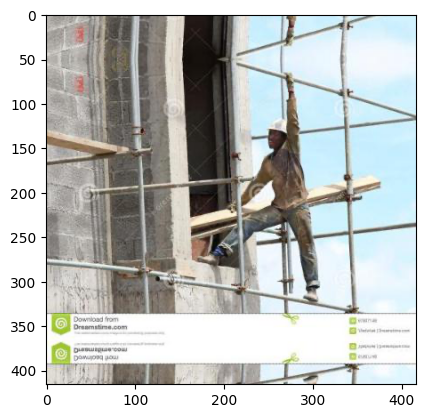

In [ ]:
plt.imshow(img_src)
plt.show()

In [ ]:
color_dict = {
    0: (255, 0, 0),
    1: (0, 255, 0),
    2: (0, 0, 255)
}


0: 224x224 6 helmets, 11.2ms
Speed: 1.1ms preprocess, 11.2ms inference, 2.3ms postprocess per image at shape (1, 3, 224, 224)


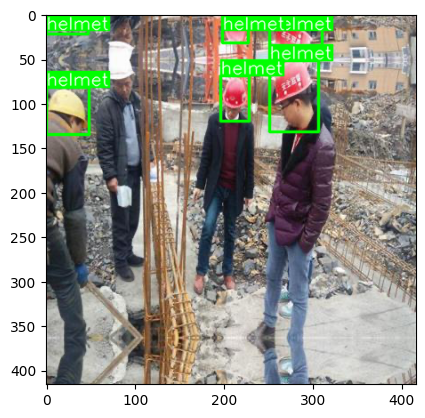

In [ ]:
num_head = 0
test_img = cv2.imread(test_file_list[1])
img_src = cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB)
result = model(img_src)[0]

annotator = Annotator(img_src)
boxes = result.boxes

for box in boxes:
    b = box.xyxy[0]
    cls = box.cls
    if 'head' == model.names[int(cls)]:
        num_head += 1
    annotator.box_label(b, model.names[int(cls)], color_dict[int(cls)])
img_src = annotator.result()
if num_head > 0:
    cv2.rectangle(img_src, (0, 0), (300, 50), (255, 0, 0), -1, cv2.LINE_AA)
    cv2.putText(img_src, 'No Helmet!', (5, 30), cv2.FONT_HERSHEY_DUPLEX, 1, (255, 255, 255), thinkness=3, lineType=cv2.LINE_AA)
plt.imshow(img_src)
plt.show()

In [ ]:
plt.figure(figsize=(20, 16))

for idx in range(20):
    num_head = 0
    test_img = cv2.imread(test_file_list[idx])
    img_src = cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB)
    result = model(img_src)[0]

    annotator = Annotator(img_src)
    boxes = result.boxes

    for box in boxes:
        b = box.xyxy[0]
        cls = box.cls
        if 'head' == model.names[int(cls)]:
            num_head += 1
        annotator.box_label(b, model.names[int(cls)], color_dict[int(cls)])
    img_src = annotator.result()

    plt.subplot(5, 4, (idx+1))
    if num_head > 0:
        cv2.rectangle(img_src, (0, 0), (300, 50), (255, 0, 0), -1, cv2.LINE_AA)
        cv2.putText(img_src, 'No Helmet!', (5, 30), cv2.FONT_HERSHEY_DUPLEX, 1, (255, 255, 255), lineType=cv2.LINE_AA)
    plt.imshow(img_src)
plt.show()

In [ ]:
len(test_file_list)

500